<a href="https://colab.research.google.com/github/mudogruer/sheaf_laplacian_deception_analysis/blob/main/ER_sheaf_laplacian_deception_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Bu projede, bir **social network** senaryosunda yalan (deception) ve durustluk (honesty) etkilesimini inceleyecegiz
“Sheaf Laplacian” temelli bir **Laplacian centrality** analizini gerçeklestiriyoruz.  
Özetle:

1. **Erdos-Renyi (ER) graflari** olusturuyoruz (ör. \\( n=100 \\), \\( p=0.1 \\)).
2. Her node (kullanıcıya) “honest” (durust), “prosocial liar” (toplumsal yarar gozeten yalanci)
   veya “antisocial liar” (zarar veya dezenformasyon amacıyla yalancı) tipi atiyoruz.
3. Rastgele \\( x_u \\) değerleri atiyoruz (her node'un ozel fikrini ifade ediyor).  
4. **Public opinion** (kamuya aciklanan fikir) modeli:  
   - Honest tipler kendi ozel fikirlerini (veya belli bir oranda) yansitir.  
   - Prosocial liar, komşularının fikirlerini de dikkate alarak (pozitif yonlu) carpitma yapar.  
   - Antisocial liar, komşuların fikirlerini (negatif yonlu) carpitir vb.  
   Bunu, makaledeki “Algorithm 1” mantigina uygun olarak yapacagiz.
5. Her node'un **Laplacian centrality** degerini, “sheaf Laplacian” uzerinden hesapliyoruz.  
   - Laplacian centrality için, bir node'un yokluğunda network'un “Laplacian energy"sinin ne kadar azaldığına bakıyoruz.  
6. \\( \\tau \\) (honesty parameter) değerini 0’dan 1’e cesitli steplerle degistirerek,
   hangi tip dugunlerin (honest/prosocial/antisocial) ortalama LC skorunun nasil farklilik gosterdigine bakiyoruz.

# Kodun genel isleyisi:

- **`assign_types(n_nodes)`**: Node assign islemi (honest, prosocial, antisocial).  
- **`compute_public_opinion(G, X, types, tau)`**: Her node'un public fikrini hesaplama (\\( y_i \\)).  
- **`construct_sheaf_laplacian(G, X, types, tau, y)`**: “Disclosure” matrisi \\( B \\) ve sonrasında \\( L_{F} = B^T B \\) oluşturma.  
- **`laplacian_centrality(L, node)`**: Her node'un Laplacian centrality value'su.  
- **`run_simulation(n, p, n_trials=100, tau_steps=40)`**: Belirli bir \\( n \\) ve \\( p \\) için multi deney ve ortalama sonuçları toplama.  
- **`plot_results(tau_values, results, title)`**: Plotting.

Sonuc grafikleri, \\( \\tau \\) değerine göre 3 egri (Honest – Prosocial Liar – Antisocial Liar) seklinde
Laplacian centrality ortalamalarını yansıtacak. Bu sayede, network yapisi ve \\( \\tau \\) degisimin hangi node tipini
daha influential hale getirdiğini gorecegiz.

In [1]:
## Importing Libraries
import numpy as np #matematik ifadeleri kullanacagimiz kutuphane
import networkx as nx # ER graflarini olsturmak icin kullanacagimiz kutuphane
import matplotlib.pyplot as plt # basit plotlar olusturmak icin kullanacagimiz kutuphane
from tqdm import tqdm # kodun calisma suresini gormek icin kullanacagimiz kutuphane

## `assign_types(n_nodes)` Fonksiyonu

Bu fonksiyon, belirli sayıda node icin \\( (n\_nodes) \\) **3 farkli tip** (honest, prosocial, antisocial) atar ve bu atamayi dengeli yapmak icin 10 a bolup 3 farkli tipte atama yapar.

1. **`ranked_nodes = np.random.permutation(n_nodes)`**  
   - \\( n\_nodes \\) boyutunda bir dizi oluşturur (0’dan \\( n\_nodes-1 \\) e kadar)  
   - Daha sonra `np.random.permutation` ile bu dizinin elemanlarını rasgele sıraya koyar, “ranked_nodes” ile rastgele permutasyon kullanarak centrality siralamasi yapiyoruz.  

2. **`deciles = np.array_split(ranked_nodes, 10)`**  
   - “ranked_nodes” dizisini 10 decile'a boler.  
   - Bu sayede, her bir decile'da \\( n\_nodes / 10 \\) kadar node bulunur.

3. **Döngüyle her decile’ı işlemek:**  
   - `for decile in deciles:` döngüsüne girilir.  
   - `np.random.shuffle(decile)` once nodelar karistirilir.
   - Sonra `split = np.array_split(decile, 3)` yaparak 3 e ayiriyoruz (honest, prosocial,antisocial)

**Sum:**  
Fonksiyonun amaci, \\( n\_nodes \\) sayıda düğümü roughly equal honest/prosocial/antisocial olarak atamak.
Her decile içinde 1/3 oranında ayrım yapıldığı için, sonuç olarak node'lar yaklasik 1/3 honest,
1/3 prosocial, 1/3 antisocial olarak dagitilir.

In [2]:
def assign_types(n_nodes):
    """Assign types (honest, prosocial, antisocial) ensuring balanced distribution."""
    ranked_nodes = np.random.permutation(n_nodes)  # Replace with actual centrality ranking
    deciles = np.array_split(ranked_nodes, 10)
    types = []
    for decile in deciles:
        np.random.shuffle(decile)
        split = np.array_split(decile, 3)
        types.extend(['honest', 'prosocial', 'antisocial'][i] for i in range(3) for _ in split[i])
    return types[:n_nodes]


## `compute_public_opinion(G, X, types, tau)` Fonksiyonu

Aşağıdaki fonksiyon, **kamuya aciklanan fikirler** dizisi \\( y \\) (public opinion)
hesaplamak için tasarlandi. Her her node kendi tipine gore
(prosocial/antisocial/honest) fikrini carpitiyor ya da komsudan etkileniyor.

    Parameters:
    G     : NetworkX Graph
        Erdos-Renyi benzeri ag yapisi.
    X     : np.ndarray (shape: n)
        Node'larin private fikirlerini tutan dizi.
    types : list of str
        Node'larin tiplerini tutar; 'honest', 'prosocial', veya 'antisocial'.
        Örneğin types[i] = 'honest' ise i. node honest kisidir.
    tau   : float
        0 ile 1 arasinda degisen (T) "honesty parameter".
        Deger 1'e yaklaştıkça kullanıcı gercek fikrini daha fazla ortaya koyar;
        0'a yakinsa konsularin (veya manipulated) fikri baskin hale gelir.

    Returns:
    y :
        Her node icin public fikri y dizisinde toplanmis halde dondurur.

In [3]:
def compute_public_opinion(G, X, types, tau):
    """Compute public opinions y_i for all nodes."""
    y = np.zeros(len(G))
    for i in G.nodes():
        neighbors = list(G.neighbors(i))
        if not neighbors:
            y[i] = X[i]
            continue
        w = []
        for j in neighbors:
            if types[i] == 'honest':
                w_ji = X[i]
            elif types[i] == 'prosocial':
                w_ji = tau * X[i] + (1 - tau) * X[j]
            else:
                w_ji = tau * X[i] - (1 - tau) * X[j]
            w.append(w_ji)
        y[i] = np.mean(w)
    return y

## `construct_sheaf_laplacian(G, X, types, tau, y)` Fonksiyonu

**Sheaf Laplacian** (\\( L\_{F} \\)) matrisi olusturuyoruz.  
Makalede bahsi gecen algoritma'yi kodlamaya calistim.


    Parameters:
    -----------
    G      : NetworkX Graph
        simulasyonda kullanilan ER graph nesnesi.
    X      : np.ndarray (shape: n)
        Her node'un private fikrini tutan dizi.
    types  : list of str
        Her node'un 'honest', 'prosocial', 'antisocial' bilgisi.
    tau    : float
        0 ile 1 arasında, "honesty parameter".
    y      : np.ndarray (shape: n)
        compute_public_opinion() fonksiyonundan elde edilen deger.
    Returns:
    --------
    L_sheaf : np.ndarray (shape: n x n)
        Olusturulan sheaf Laplacian matrisi, B^T B biciminde hesaplanir.


In [4]:
def construct_sheaf_laplacian(G, X, types, tau, y):
    """Construct sheaf Laplacian using Algorithm 1."""
    m = G.number_of_edges()
    n = G.number_of_nodes()
    B = np.zeros((m, n))

    edges = list(G.edges())
    for idx, (u, v) in enumerate(edges):
        # Disclosure for u->v
        if types[u] == 'honest':
            d_u = 1
        elif types[u] == 'prosocial':
            d_u = tau + (1 - tau) * (y[v] / X[u]) if X[u] != 0 else 0
        else:
            d_u = tau - (1 - tau) * (y[v] / X[u]) if X[u] != 0 else 0

        # Disclosure for v->u
        if types[v] == 'honest':
            d_v = 1
        elif types[v] == 'prosocial':
            d_v = tau + (1 - tau) * (y[u] / X[v]) if X[v] != 0 else 0
        else:
            d_v = tau - (1 - tau) * (y[u] / X[v]) if X[v] != 0 else 0

        B[idx, u] = d_u
        B[idx, v] = -d_v

    L_sheaf = B.T @ B
    return L_sheaf

## `laplacian_centrality(L, node)` Fonksiyonu

Bu fonksiyon bir node'un **Laplacian centrality** degerini hesaplar.  
Makaledeye gore, bir node'un çıkarılması sonrasi networkun Laplacian enerjisinin ne kadar azaldigi
incelenir ve bu fark, soz konusu dugumun onemini gosterir.

    Compute Laplacian centrality for a node.
    
    Parameters:
    -----------
    L     : np.ndarray (shape: n x n)
        Sheaf Laplacian matrisi.
    node  : int
        Node indeksi.
        
    Returns:
    --------
    float
        Laplacian merkeziyet degeri.

In [5]:
def laplacian_centrality(L, node):
    """Compute Laplacian centrality for a node."""
    n = L.shape[0]
    E_L = np.trace(L @ L)  # Laplacian energy

    # Remove node (simplified)
    mask = np.ones(n, bool)
    mask[node] = False
    L_reduced = L[mask][:, mask]
    E_L_reduced = np.trace(L_reduced @ L_reduced)

    return (E_L - E_L_reduced) / E_L

## `run_simulation(n, p, n_trials=100, tau_steps=40)` Fonksiyonu

ER graf parametreleri \\( (n, p) \\) altinda
coklu simülasyon (\\( n\_trials \\) kez) calistirarak, cesitli \\( \\tau \\) degerlerinde
**honest**, **prosocial** ve **antisocial** node'larinin ortalama **Laplacian centrality** sonuclarini dondurur.

    Run simulation for given ER graph parameters.
    
    Parameters:
    -----------
    n         : int
        node sayısı.
    p         : float
        ER networkunde edge olasılığı (0..1).
    n_trials  : int, optional
        Kac kez kosturulacagi belirtiliyor.
    tau_steps : int, optional
        0..1 aralığında tau'yu kac adimda bolecegimizi belirtiyoruz.
        
    Returns:
    --------
    tau_values : np.ndarray
        0..1 arasinda tau value'larini tutan dizi.
    results    : dict of np.ndarray
        "honest", "prosocial", "antisocial" key'lerini tutar.


In [6]:
def run_simulation(n, p, n_trials=100, tau_steps=40):
    """Run simulation for given ER graph parameters."""
    tau_values = np.linspace(0, 1, tau_steps)
    results = {'honest': np.zeros(tau_steps),
               'prosocial': np.zeros(tau_steps),
               'antisocial': np.zeros(tau_steps)}

    for _ in tqdm(range(n_trials)):
        G = nx.erdos_renyi_graph(n, p)
        if not nx.is_connected(G):
            continue  # Skip disconnected graphs

        X = np.random.uniform(-1, 1, n)
        types = assign_types(n)

        for tau_idx, tau in enumerate(tau_values):
            y = compute_public_opinion(G, X, types, tau)
            L_sheaf = construct_sheaf_laplacian(G, X, types, tau, y)

            # Compute centralities
            centralities = [laplacian_centrality(L_sheaf, node) for node in range(n)]

            # Aggregate by type
            for i, t in enumerate(types):
                results[t][tau_idx] += centralities[i]

    # Average results
    for key in results:
        results[key] /= n_trials
    return tau_values, results

In [7]:
# ================== Plotting ==================
def plot_results(tau_values, results, title):
    plt.figure(figsize=(8, 5))
    plt.plot(tau_values, results['honest'], label='Honest', linestyle='--')
    plt.plot(tau_values, results['prosocial'], label='Prosocial Liar')
    plt.plot(tau_values, results['antisocial'], label='Antisocial Liar')
    plt.xlabel('Honesty Parameter (τ)')
    plt.ylabel('Average Laplacian Centrality')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


100%|██████████| 100/100 [02:15<00:00,  1.35s/it]


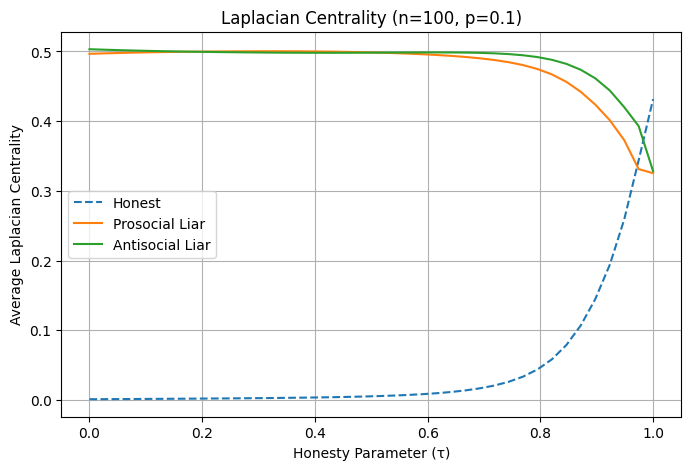

In [8]:
# ================== Run for All Graphs ==================
# For n=100, p=0.1
tau_vals, res = run_simulation(n=100, p=0.1)
plot_results(tau_vals, res, 'Laplacian Centrality (n=100, p=0.1)')

100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


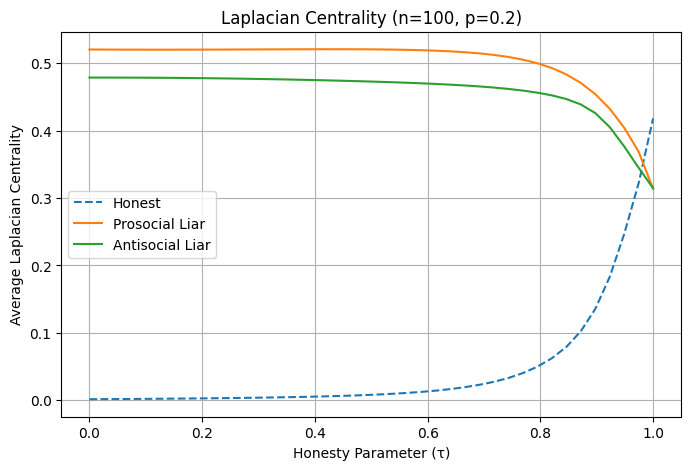

In [9]:
# For n=100, p=0.2
tau_vals, res = run_simulation(n=100, p=0.2)
plot_results(tau_vals, res, 'Laplacian Centrality (n=100, p=0.2)')

100%|██████████| 100/100 [20:19<00:00, 12.20s/it]


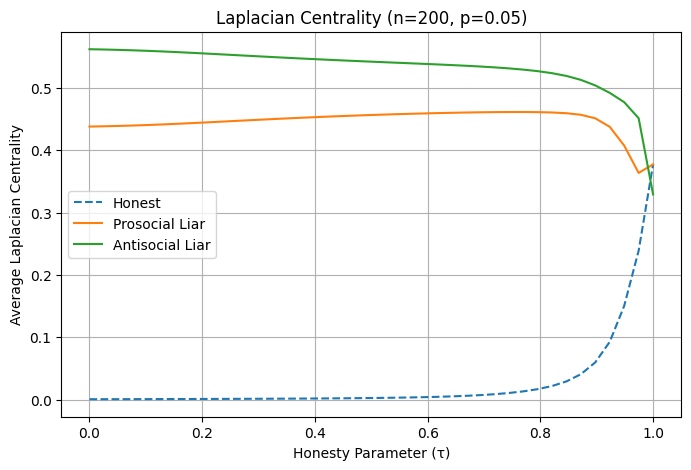

In [10]:
# For n=200, p=0.05
tau_vals, res = run_simulation(n=200, p=0.05)
plot_results(tau_vals, res, 'Laplacian Centrality (n=200, p=0.05)')